In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [2]:
## Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [3]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [4]:

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_cont2"] = estreams_attributes["perm_high_cont"]
estreams_attributes["perm_medium_cont2"] = estreams_attributes["perm_medium_cont"] + estreams_attributes["perm_low_cont"]
estreams_attributes["perm_low_cont2"] = estreams_attributes["perm_verylow_cont"]


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [41]:
estreams_attributes.loc["FR002029"]

gauge_id                                  Q312003001
gauge_name                                  Q3120030
gauge_country                                     FR
gauge_provider                          FR_EAUFRANCE
river                L'Adour à Dax [Pont des arènes]
                                  ...               
perm_medium_glob2                               41.0
perm_low_glob2                                   0.0
perm_high_cont2                               61.034
perm_medium_cont2                             35.948
perm_low_cont2                                 3.016
Name: FR002029, Length: 125, dtype: object

In [ ]:
FR002029

In [ ]:
FR003922, FR002029, BEVL0155, ES001243

In [5]:
BASIN_ID = "FR002029"

In [6]:
# First we define the outlet of the Moselle to be used
outlets = [BASIN_ID]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs[BASIN_ID]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]
estreams_attributes_clipped_filters

100%|██████████| 1/1 [00:00<00:00, 1468.59it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR004389,Q012006002,L'Adour Ã Tarbes,FR,FR_EAUFRANCE,L'Adour à Tarbes,0.088685,43.231731,0.088685,43.231731,309,...,15.724,0.000,0.000,5.0,31.0,62.0,7.0,10.833,28.236,60.930
FR004391,Q021401001,L'Echez Ã Louey,FR,FR_EAUFRANCE,L'Echez à Louey,0.022191,43.175522,0.022191,43.175522,333,...,0.720,0.000,0.000,2.0,35.0,64.0,1.0,28.238,71.762,0.000
FR004393,Q028003001,L'Adour Ã Estirac,FR,FR_EAUFRANCE,L'Adour à Estirac,0.028681,43.498162,0.028681,43.498162,164,...,7.153,119.371,100.522,9.0,60.0,37.0,3.0,41.348,31.925,26.727
FR004395,Q036001001,L'Adour Ã HÃ¨res [Ju Belloc],FR,FR_EAUFRANCE,L'Adour à Hères [Ju Belloc],0.000119,43.562689,0.000119,43.562689,149,...,5.703,178.720,163.402,9.0,64.0,34.0,2.0,50.265,28.706,21.030
FR004396,Q052252001,L'Arros Ã Gourgue,FR,FR_EAUFRANCE,L'Arros à Gourgue,0.259233,43.131532,0.259233,43.131532,292,...,1.898,0.000,0.000,2.0,11.0,88.0,1.0,0.000,99.998,0.002
FR004397,Q052253001,L'Arros Ã Tournay,FR,FR_EAUFRANCE,L'Arros à Tournay,0.241107,43.184080,0.241107,43.184080,263,...,1.549,0.000,0.000,2.0,25.0,74.0,1.0,4.895,95.103,0.002
FR004399,Q061251001,L'Arros Ã Juillac,FR,FR_EAUFRANCE,L'Arros à Juillac,0.108653,43.545043,0.108653,43.545043,140,...,0.829,44.776,46.909,3.0,44.0,56.0,0.0,21.390,78.610,0.001
FR004406,Q074002001,L'Adour Ã Riscle,FR,FR_EAUFRANCE,L'Adour à Riscle,-0.081043,43.663886,-0.081043,43.663886,102,...,3.096,340.353,357.479,11.0,58.0,41.0,1.0,41.783,47.867,10.350
FR004407,Q109402001,Le LÃ©es Ã BernÃ¨de et Ã Lannux,FR,FR_EAUFRANCE,Le Lées à Bernède et à Lannux,-0.234488,43.647182,-0.234488,43.647182,89,...,0.394,63.836,86.870,3.0,46.0,54.0,0.0,44.622,55.378,0.000


In [7]:
estreams_attributes_clipped_filters.corr(method="spearman")["baseflow_index"][-10:]

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_64127/3158332290.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped_filters.corr(method="spearman")["baseflow_index"][-10:]


sno_cov_mean           0.693794
irri_1990             -0.263433
irri_2005             -0.253075
stations_num_p_mean    0.303230
perm_high_glob2        0.052172
perm_medium_glob2     -0.080021
perm_low_glob2         0.631686
perm_high_cont2       -0.207557
perm_medium_cont2     -0.582664
perm_low_cont2         0.746672
Name: baseflow_index, dtype: float64

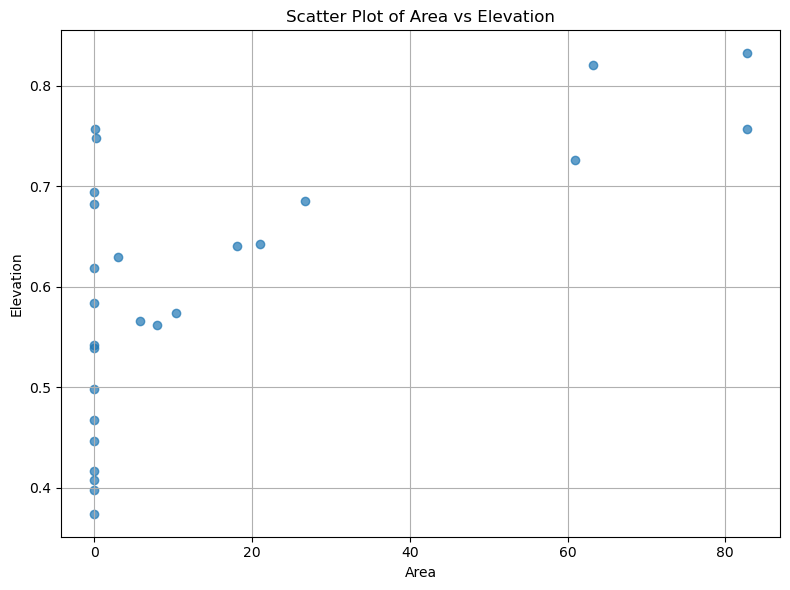

In [8]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_cont2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


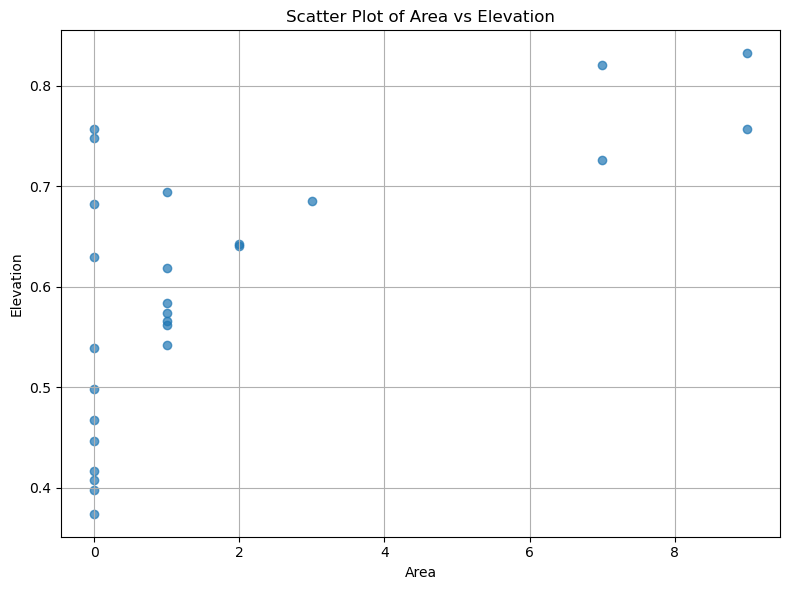

In [9]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_glob2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
len(estreams_attributes_clipped_filters)

26

In [11]:
estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR004389,Q012006002,L'Adour Ã Tarbes,FR,FR_EAUFRANCE,L'Adour à Tarbes,0.088685,43.231731,0.088685,43.231731,309,...,15.724,0.000,0.000,5.0,31.0,62.0,7.0,10.833,28.236,60.930
FR004391,Q021401001,L'Echez Ã Louey,FR,FR_EAUFRANCE,L'Echez à Louey,0.022191,43.175522,0.022191,43.175522,333,...,0.720,0.000,0.000,2.0,35.0,64.0,1.0,28.238,71.762,0.000
FR004393,Q028003001,L'Adour Ã Estirac,FR,FR_EAUFRANCE,L'Adour à Estirac,0.028681,43.498162,0.028681,43.498162,164,...,7.153,119.371,100.522,9.0,60.0,37.0,3.0,41.348,31.925,26.727
FR004395,Q036001001,L'Adour Ã HÃ¨res [Ju Belloc],FR,FR_EAUFRANCE,L'Adour à Hères [Ju Belloc],0.000119,43.562689,0.000119,43.562689,149,...,5.703,178.720,163.402,9.0,64.0,34.0,2.0,50.265,28.706,21.030
FR004396,Q052252001,L'Arros Ã Gourgue,FR,FR_EAUFRANCE,L'Arros à Gourgue,0.259233,43.131532,0.259233,43.131532,292,...,1.898,0.000,0.000,2.0,11.0,88.0,1.0,0.000,99.998,0.002
FR004397,Q052253001,L'Arros Ã Tournay,FR,FR_EAUFRANCE,L'Arros à Tournay,0.241107,43.184080,0.241107,43.184080,263,...,1.549,0.000,0.000,2.0,25.0,74.0,1.0,4.895,95.103,0.002
FR004399,Q061251001,L'Arros Ã Juillac,FR,FR_EAUFRANCE,L'Arros à Juillac,0.108653,43.545043,0.108653,43.545043,140,...,0.829,44.776,46.909,3.0,44.0,56.0,0.0,21.390,78.610,0.001
FR004406,Q074002001,L'Adour Ã Riscle,FR,FR_EAUFRANCE,L'Adour à Riscle,-0.081043,43.663886,-0.081043,43.663886,102,...,3.096,340.353,357.479,11.0,58.0,41.0,1.0,41.783,47.867,10.350
FR004407,Q109402001,Le LÃ©es Ã BernÃ¨de et Ã Lannux,FR,FR_EAUFRANCE,Le Lées à Bernède et à Lannux,-0.234488,43.647182,-0.234488,43.647182,89,...,0.394,63.836,86.870,3.0,46.0,54.0,0.0,44.622,55.378,0.000


In [12]:
basins_problems2 = pd.read_csv(r"../data/basins_problems_filter_2.csv")
basins_problems2

,basin
0,AT000080
1,AT000120
2,AT000159
3,AT000372
4,AT000373
...,...
369,SE000083
370,SE000103
371,SE000118
372,SI000029


In [13]:
Outliers = ["DEBB0050", 
"DK000087",
"ES000172",
"ES000478",
"ES001114",
"FI000202",
"FI000506",
"FR001271",
"FR001475",
"ITIS0107",
"NL000012",
"PT000211",
"PT000218",
"PT000263",
"DEHE0953",
"DEHE0970",
"DEHE0989",
"DEHE1008",
"DEHE1013",
"DEHE1014",
"DK000094"]

In [14]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[~estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]
#estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters2.drop(["FR001217", "FR001219", "FR003943", "FR001180"])

len(estreams_attributes_clipped_filters2)

25

In [36]:
# Create a folder to save the plots
output_dir = r"../results/plots/talavera"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    #csv_file = fr"C:/Users/nascimth/Documents/data/EStreams/data/estreams_timeseries_{basin_id}.csv"
    csv_file = fr'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Data/data/estreams_timeseries_{basin_id}.csv'
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.xlim("1988","2015")

    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 26/26 [00:02<00:00, 12.14it/s]


In [21]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters2.drop([ 
"FR001987"
])


KeyError: "['FR001987'] not found in axis"

<Axes: >

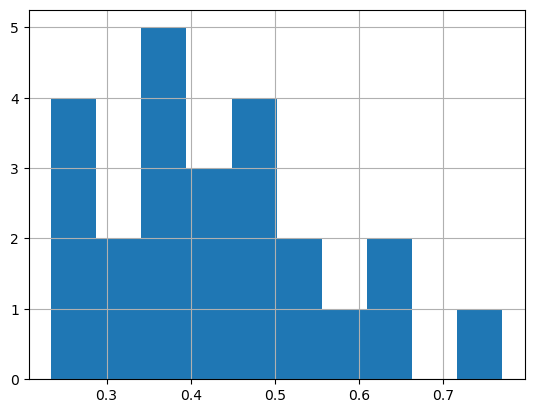

In [22]:
estreams_attributes_clipped_filters2.q_runoff_ratio.hist()

In [23]:
estreams_attributes_clipped_filters2[estreams_attributes_clipped_filters2.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
FR004415    0.243
FR004416    0.234
FR004418    0.284
FR004420    0.296
FR002026    0.261
Name: q_runoff_ratio, dtype: float64

In [24]:
estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR004389,Q012006002,L'Adour Ã Tarbes,FR,FR_EAUFRANCE,L'Adour à Tarbes,0.088685,43.231731,0.088685,43.231731,309,...,15.724,0.000,0.000,5.0,31.0,62.0,7.0,10.833,28.236,60.930
FR004391,Q021401001,L'Echez Ã Louey,FR,FR_EAUFRANCE,L'Echez à Louey,0.022191,43.175522,0.022191,43.175522,333,...,0.720,0.000,0.000,2.0,35.0,64.0,1.0,28.238,71.762,0.000
FR004393,Q028003001,L'Adour Ã Estirac,FR,FR_EAUFRANCE,L'Adour à Estirac,0.028681,43.498162,0.028681,43.498162,164,...,7.153,119.371,100.522,9.0,60.0,37.0,3.0,41.348,31.925,26.727
FR004395,Q036001001,L'Adour Ã HÃ¨res [Ju Belloc],FR,FR_EAUFRANCE,L'Adour à Hères [Ju Belloc],0.000119,43.562689,0.000119,43.562689,149,...,5.703,178.720,163.402,9.0,64.0,34.0,2.0,50.265,28.706,21.030
FR004396,Q052252001,L'Arros Ã Gourgue,FR,FR_EAUFRANCE,L'Arros à Gourgue,0.259233,43.131532,0.259233,43.131532,292,...,1.898,0.000,0.000,2.0,11.0,88.0,1.0,0.000,99.998,0.002
FR004397,Q052253001,L'Arros Ã Tournay,FR,FR_EAUFRANCE,L'Arros à Tournay,0.241107,43.184080,0.241107,43.184080,263,...,1.549,0.000,0.000,2.0,25.0,74.0,1.0,4.895,95.103,0.002
FR004399,Q061251001,L'Arros Ã Juillac,FR,FR_EAUFRANCE,L'Arros à Juillac,0.108653,43.545043,0.108653,43.545043,140,...,0.829,44.776,46.909,3.0,44.0,56.0,0.0,21.390,78.610,0.001
FR004406,Q074002001,L'Adour Ã Riscle,FR,FR_EAUFRANCE,L'Adour à Riscle,-0.081043,43.663886,-0.081043,43.663886,102,...,3.096,340.353,357.479,11.0,58.0,41.0,1.0,41.783,47.867,10.350
FR004407,Q109402001,Le LÃ©es Ã BernÃ¨de et Ã Lannux,FR,FR_EAUFRANCE,Le Lées à Bernède et à Lannux,-0.234488,43.647182,-0.234488,43.647182,89,...,0.394,63.836,86.870,3.0,46.0,54.0,0.0,44.622,55.378,0.000


In [25]:
import pandas as pd
import os
import tqdm

data_folder = r"C:/Users/nascimth/Documents/data/EStreams/data"
data_folder = fr'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Data/data/'

gantt_segments = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters2.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")

    # Load CSV with datetime index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data.loc["1988-10-01":"2015-09-30"]

    # Get availability mask
    valid = data["q_mean"].notna()

    # Identify change points in availability (True to False or vice-versa)
    change_points = valid.ne(valid.shift()).cumsum()

    # Group by continuous segments
    for grp, seg in data[valid].groupby(change_points):
        start = seg.index.min()
        end = seg.index.max()
        gantt_segments.append((basin_id, start, end))


100%|██████████| 24/24 [00:00<00:00, 41.86it/s]


In [26]:
gantt_df = pd.DataFrame(gantt_segments, columns=["basin", "start", "end"])
gantt_df = gantt_df.sort_values(["basin", "start"]).reset_index(drop=True)

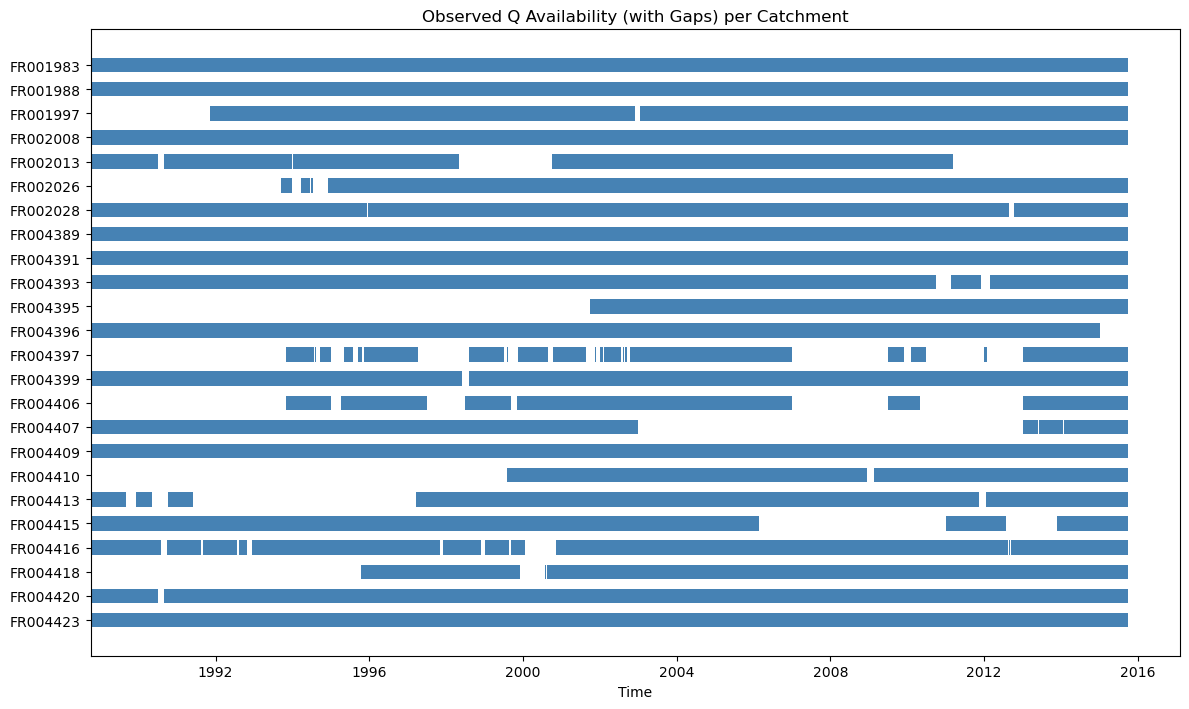

In [27]:
import matplotlib.pyplot as plt

# Assign a numeric index for plotting on y-axis
basin_to_y = {basin: i for i, basin in enumerate(gantt_df["basin"].unique())}
gantt_df["y"] = gantt_df["basin"].map(basin_to_y)

fig, ax = plt.subplots(figsize=(12, len(basin_to_y) * 0.3))

for _, row in gantt_df.iterrows():
    width = (row["end"] - row["start"]).days
    ax.barh(y=row["y"], left=row["start"], width=width, height=0.6, color="steelblue")

ax.set_yticks(list(basin_to_y.values()))
ax.set_yticklabels(list(basin_to_y.keys()))
ax.invert_yaxis()
ax.set_xlabel("Time")
ax.set_title("Observed Q Availability (with Gaps) per Catchment")
plt.tight_layout()
plt.show()


In [28]:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes_clipped_filters2.copy()

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

estreams_attributes_clipped_sorted.loc[:, ["area_estreams"]]

,area_estreams
basin_id,
FR004410,56.446
FR004423,88.511
FR004391,91.107
FR002026,130.381
FR002008,143.055
FR001988,164.379
FR004396,182.692
FR004415,219.484
FR004397,238.318


In [30]:
import geopandas as gpd
moselle=gpd.read_file(r"../data/shps\moselle_delienation.shp")
garonne=gpd.read_file(r"..\data\shps\garonne.shp")
five_cats=gpd.read_file(r"..\data\shps\five_cats.shp")

rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

### Current approach

In [29]:
import numpy as np
import pandas as pd

# Parameters
n_groups = 2

# Base dataframe
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

total_gauges = len(df_sorted)

# Step 1: Sort by area for stratification
df_sorted = df_sorted.sort_values(by="area_estreams").reset_index(drop=True)

# Step 2: Determine gauges per group
gauges_per_group = total_gauges // n_groups
extra_gauges = total_gauges % n_groups  # Remainder

# Step 3: Create strata for balanced sampling
strata = np.array_split(df_sorted, total_gauges)

# Step 4: Round-robin assignment with randomness
np.random.seed(42)
grouped_gauges = {f'Group_{i+1}': [] for i in range(n_groups)}
group_cycle = list(grouped_gauges.keys()) * ((len(strata) // n_groups) + 2)
group_idx = 0

for stratum in strata:
    selected = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    group = group_cycle[group_idx]
    grouped_gauges[group].append(selected)
    group_idx += 1

# Step 5: Convert to DataFrames
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}
all_combined = pd.concat(groups_df.values())

# Final checks
print(f"\n✅ Total gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# Summary per group
for k, g in groups_df.items():
    print(f"{k}: {len(g)} gauges | Mean area: {g['area_estreams'].mean():.1f}")



✅ Total gauges assigned: 24 (should be 24)
✅ Unique basin_ids: 24 (should be 24)
✅ Any duplicates? False
Group_1: 12 gauges | Mean area: 899.4
Group_2: 12 gauges | Mean area: 1376.6


In [30]:
groups_df["Group_1"]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id
0,Q122402002,Le Bahus Ã Classun et Ã EugÃ©nie-les-Bains,FR,FR_EAUFRANCE,Le Bahus à Classun et à Eugénie-les-Bains,-0.405211,43.711595,-0.405211,43.711595,80,...,28.388,33.168,1.0,59.0,41.0,0.0,12.912,87.088,0.000,FR004410
1,Q021401001,L'Echez Ã Louey,FR,FR_EAUFRANCE,L'Echez à Louey,0.022191,43.175522,0.022191,43.175522,333,...,0.000,0.000,2.0,35.0,64.0,1.0,28.238,71.762,0.000,FR004391
2,Q132401001,Q1324010,FR,FR_EAUFRANCE,Le Gabas à Poursiugues-Boucoue,-0.351557,43.554630,-0.351557,43.554630,119,...,5.182,10.786,4.0,91.0,9.0,0.0,37.239,62.761,0.000,FR002008
3,Q052252001,L'Arros Ã Gourgue,FR,FR_EAUFRANCE,L'Arros à Gourgue,0.259233,43.131532,0.259233,43.131532,292,...,0.000,0.000,2.0,11.0,88.0,1.0,0.000,99.998,0.002,FR004396
4,Q052253001,L'Arros Ã Tournay,FR,FR_EAUFRANCE,L'Arros à Tournay,0.241107,43.184080,0.241107,43.184080,263,...,0.000,0.000,2.0,25.0,74.0,1.0,4.895,95.103,0.002,FR004397
5,Q012006002,L'Adour Ã Tarbes,FR,FR_EAUFRANCE,L'Adour à Tarbes,0.088685,43.231731,0.088685,43.231731,309,...,0.000,0.000,5.0,31.0,62.0,7.0,10.833,28.236,60.930,FR004389
6,Q109402001,Le LÃ©es Ã BernÃ¨de et Ã Lannux,FR,FR_EAUFRANCE,Le Lées à Bernède et à Lannux,-0.234488,43.647182,-0.234488,43.647182,89,...,63.836,86.870,3.0,46.0,54.0,0.0,44.622,55.378,0.000,FR004407
7,Q061251001,L'Arros Ã Juillac,FR,FR_EAUFRANCE,L'Arros à Juillac,0.108653,43.545043,0.108653,43.545043,140,...,44.776,46.909,3.0,44.0,56.0,0.0,21.390,78.610,0.001,FR004399
8,Q028003001,L'Adour Ã Estirac,FR,FR_EAUFRANCE,L'Adour à Estirac,0.028681,43.498162,0.028681,43.498162,164,...,119.371,100.522,9.0,60.0,37.0,3.0,41.348,31.925,26.727,FR004393
9,Q045001001,Q0450010,FR,FR_EAUFRANCE,L'Adour à Cahuzac-sur-Adour,-0.019905,43.641092,-0.019905,43.641092,120,...,186.472,175.009,9.0,66.0,32.0,2.0,49.819,32.112,18.068,FR001997


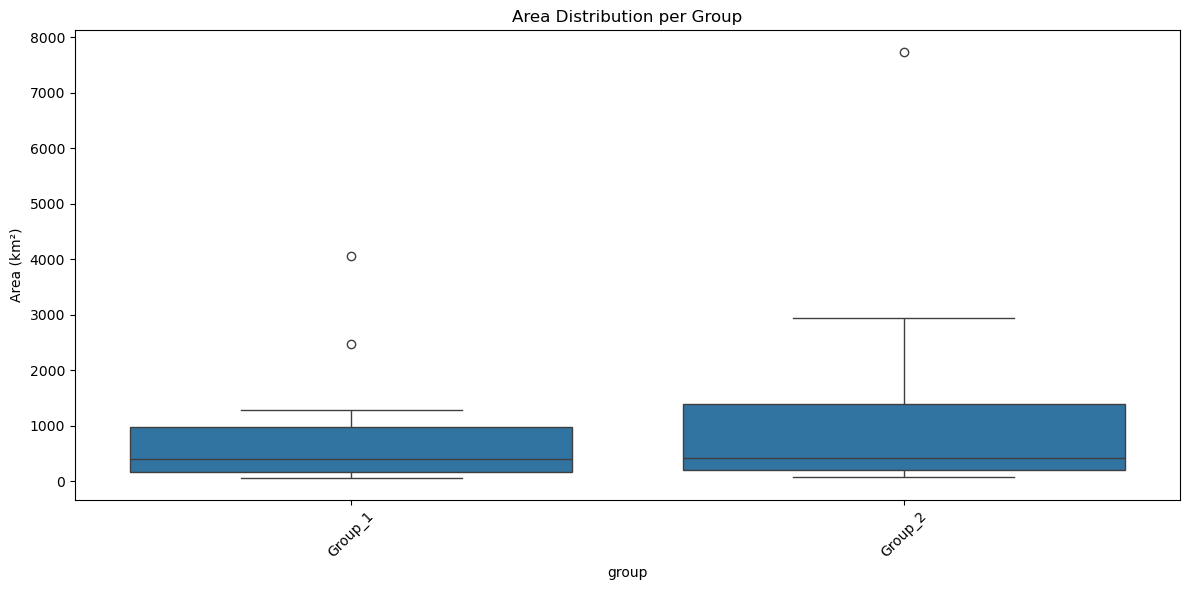

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: >

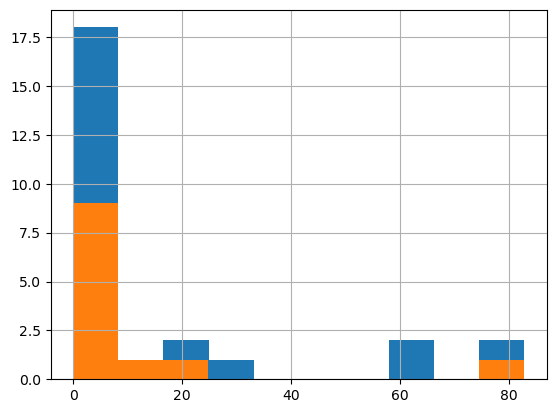

In [36]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters.perm_low_cont2.hist()
estreams_attributes_clipped_filters.loc[list_cal].sort_values("area_estreams").perm_low_cont2.hist()

<Axes: >

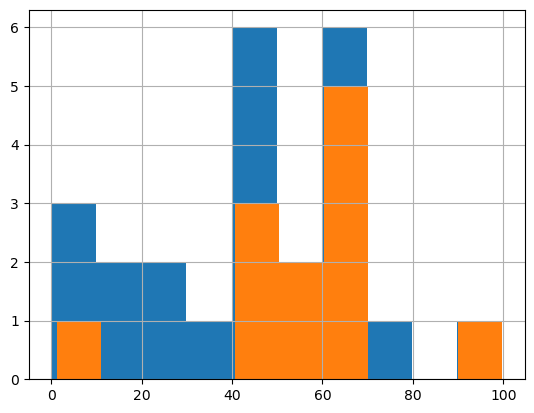

In [38]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters2.perm_high_cont2.hist()
estreams_attributes_clipped_filters2.loc[list_cal].sort_values("area_estreams").perm_high_cont2.hist()

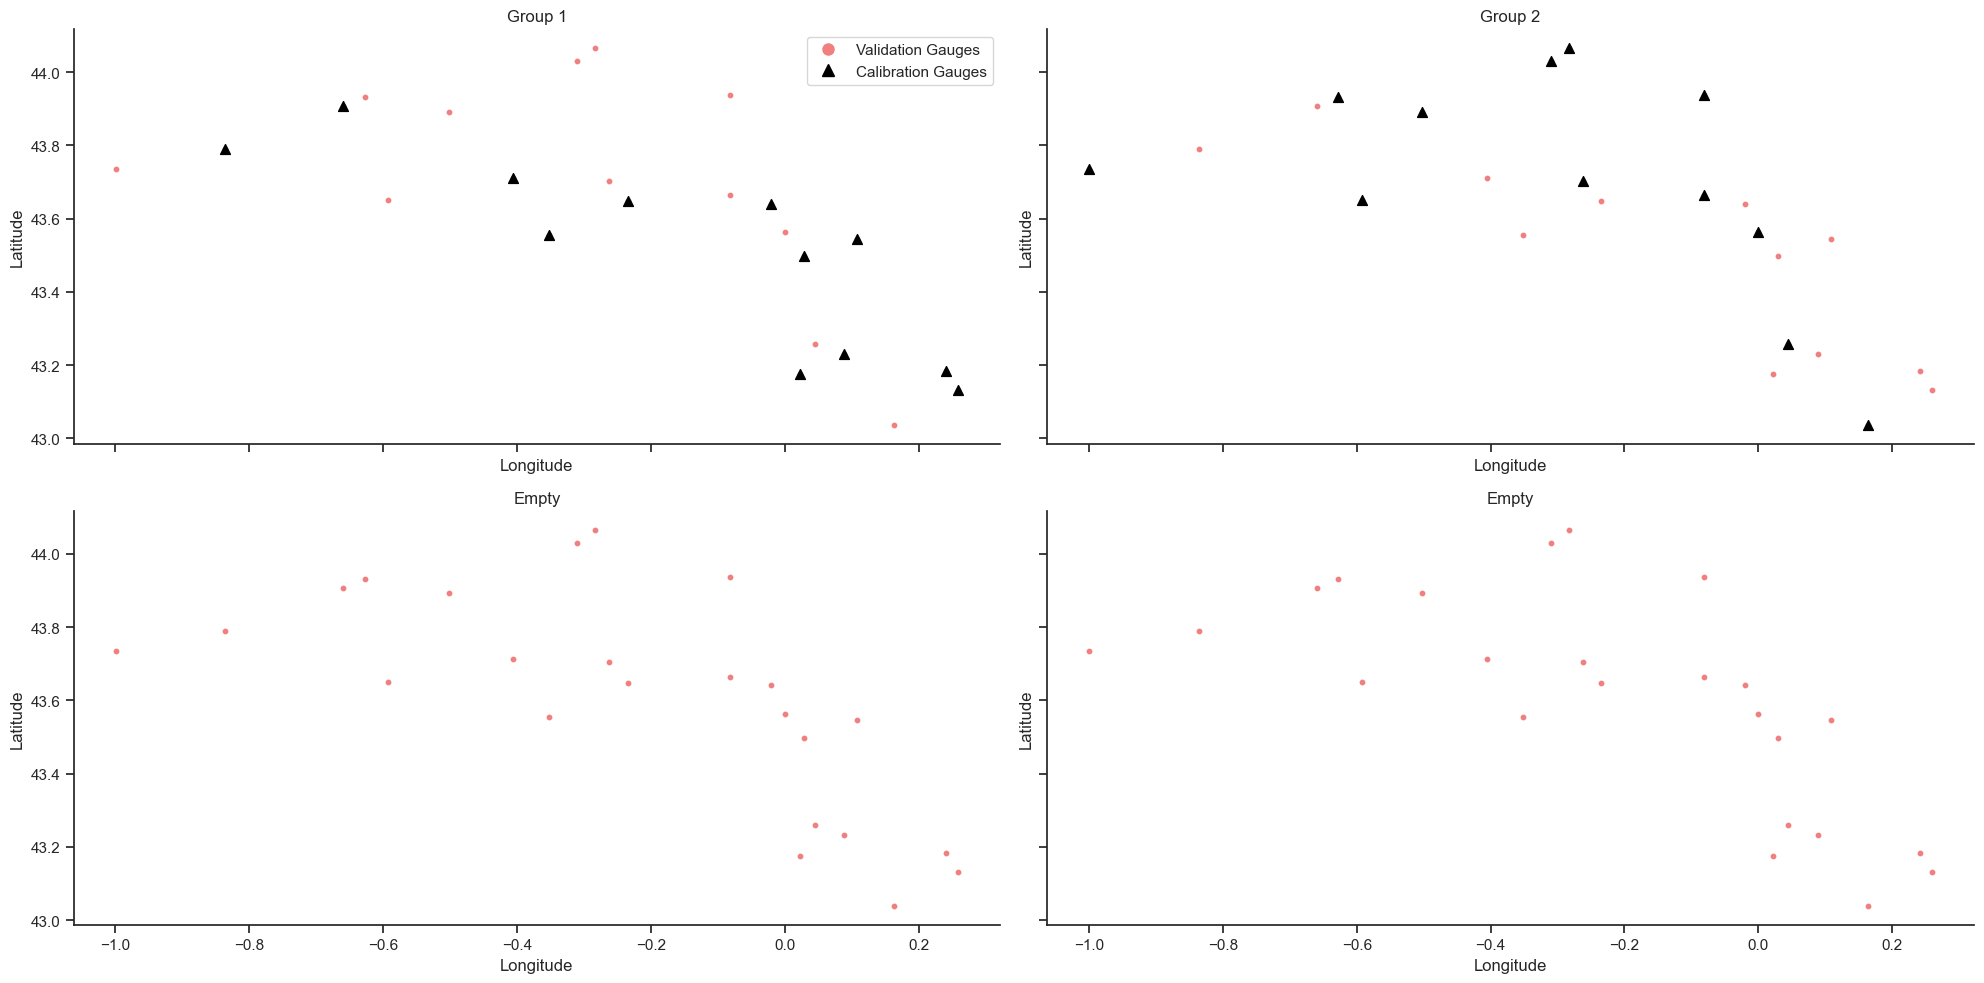

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

sns.set_theme(style="ticks")

# Prepare data
df = estreams_attributes_clipped_filters2.copy()
group_coords = [group[["basin_id"]] for group in groups_df.values()]
group_coords = [network_estreams.loc[g["basin_id"].tolist()] for g in group_coords]

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Base map
    #five_cats[five_cats.basin_id == "FR003986"].plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    #rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # All gauges in red (background)
    ax.scatter(
        df["lon"], df["lat"],
        color='lightcoral', s=10, label='Validation Gauges', zorder=2
    )

    if i < len(group_coords):
        # Plot group gauges (triangle)
        ax.scatter(
            group_coords[i]["lon"],
            group_coords[i]["lat"],
            marker='^',
            color='black',
            s=50,
            zorder=3,
            label=f'Group {i+1}'
        )
        ax.set_title(f"Group {i+1}")
    else:
        ax.set_title("Empty")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(False)
    sns.despine(ax=ax)

# Legend (shared handles)
validation_handle = mlines.Line2D([], [], color='lightcoral', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')
axes[0].legend(handles=[validation_handle, calibration_handle], loc='upper right')

plt.tight_layout()
plt.show()


In [40]:
combined_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,Q122402002,Le Bahus Ã Classun et Ã EugÃ©nie-les-Bains,FR,FR_EAUFRANCE,Le Bahus à Classun et à Eugénie-les-Bains,-0.405211,43.711595,-0.405211,43.711595,80,...,33.168,1.0,59.0,41.0,0.0,12.912,87.088,0.000,FR004410,Group_1
1,Q021401001,L'Echez Ã Louey,FR,FR_EAUFRANCE,L'Echez à Louey,0.022191,43.175522,0.022191,43.175522,333,...,0.000,2.0,35.0,64.0,1.0,28.238,71.762,0.000,FR004391,Group_1
2,Q132401001,Q1324010,FR,FR_EAUFRANCE,Le Gabas à Poursiugues-Boucoue,-0.351557,43.554630,-0.351557,43.554630,119,...,10.786,4.0,91.0,9.0,0.0,37.239,62.761,0.000,FR002008,Group_1
3,Q052252001,L'Arros Ã Gourgue,FR,FR_EAUFRANCE,L'Arros à Gourgue,0.259233,43.131532,0.259233,43.131532,292,...,0.000,2.0,11.0,88.0,1.0,0.000,99.998,0.002,FR004396,Group_1
4,Q052253001,L'Arros Ã Tournay,FR,FR_EAUFRANCE,L'Arros à Tournay,0.241107,43.184080,0.241107,43.184080,263,...,0.000,2.0,25.0,74.0,1.0,4.895,95.103,0.002,FR004397,Group_1
5,Q012006002,L'Adour Ã Tarbes,FR,FR_EAUFRANCE,L'Adour à Tarbes,0.088685,43.231731,0.088685,43.231731,309,...,0.000,5.0,31.0,62.0,7.0,10.833,28.236,60.930,FR004389,Group_1
6,Q109402001,Le LÃ©es Ã BernÃ¨de et Ã Lannux,FR,FR_EAUFRANCE,Le Lées à Bernède et à Lannux,-0.234488,43.647182,-0.234488,43.647182,89,...,86.870,3.0,46.0,54.0,0.0,44.622,55.378,0.000,FR004407,Group_1
7,Q061251001,L'Arros Ã Juillac,FR,FR_EAUFRANCE,L'Arros à Juillac,0.108653,43.545043,0.108653,43.545043,140,...,46.909,3.0,44.0,56.0,0.0,21.390,78.610,0.001,FR004399,Group_1
8,Q028003001,L'Adour Ã Estirac,FR,FR_EAUFRANCE,L'Adour à Estirac,0.028681,43.498162,0.028681,43.498162,164,...,100.522,9.0,60.0,37.0,3.0,41.348,31.925,26.727,FR004393,Group_1
9,Q045001001,Q0450010,FR,FR_EAUFRANCE,L'Adour à Cahuzac-sur-Adour,-0.019905,43.641092,-0.019905,43.641092,120,...,175.009,9.0,66.0,32.0,2.0,49.819,32.112,18.068,FR001997,Group_1


In [42]:
combined_df.to_csv("../data/network_estreams_adour_24_gauges.csv")

# End